# Test for Google Colab Instance

In [ ]:
print("Test for Google Colab")

Test for Google Colab


# Verify the GPU enabled

Changed the resource gpu to T4 GPU

In [ ]:
!nvidia-smi

Tue Dec 16 20:42:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Setting up environment...
/content
Cloning repository...
✓ Repository cloned
/content/pytorch-openpose

✓ Model downloaded
✓ Monkey Patch Applied

Running Inference...

[System] Starting Structural Weight Transfer...
[System] Successfully mapped 184/184 layers.
✓ Model loaded successfully!
Processing: /content/test_data/test.jpg


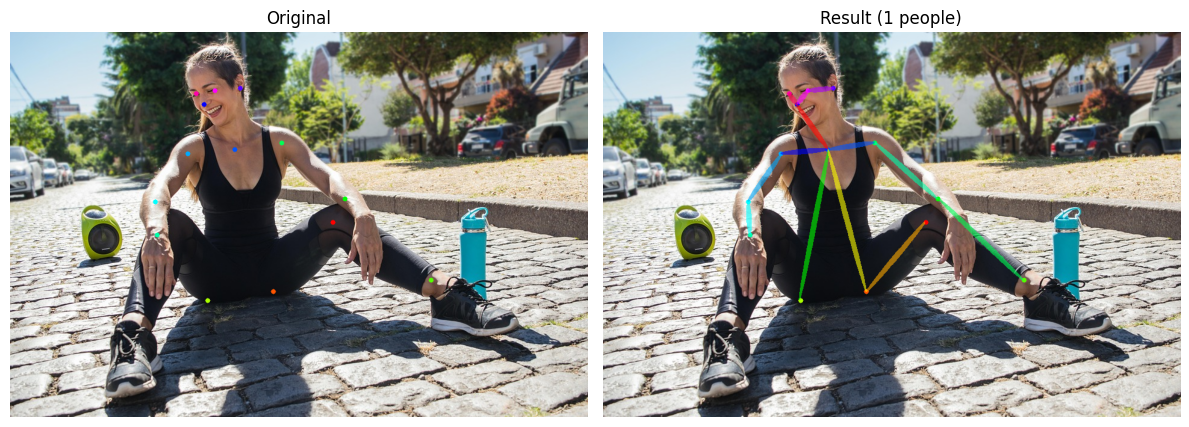


✓ Process Complete.


In [13]:
import os
import sys
import shutil
import urllib.request
import cv2
import matplotlib.pyplot as plt
import torch
import re

# 1. SETUP & CLEAN INSTALL
# ==============================================================================
print("Setting up environment...")
%cd /content

if os.path.exists('pytorch-openpose'):
    shutil.rmtree('pytorch-openpose')

print("Cloning repository...")
!git clone https://github.com/Hzzone/pytorch-openpose.git > /dev/null 2>&1
print("✓ Repository cloned")

%cd /content/pytorch-openpose
sys.path.insert(0, '/content/pytorch-openpose')


# 2. DOWNLOAD ASSETS
# ==============================================================================
print("\n" + "="*60)
print("Downloading assets...")
print("="*60)

os.makedirs('model', exist_ok=True)
model_path = 'model/body_pose_model.pth'

if not os.path.exists(model_path):
    print("Downloading Body Pose Model...")
    urllib.request.urlretrieve(
        'https://www.dropbox.com/s/5v654d2u65fuvyr/body_pose_model.pth?dl=1',
        model_path
    )
    print("✓ Model downloaded")

os.makedirs('../test_data', exist_ok=True)
image_path = '/content/test_data/test.jpg'
if not os.path.exists(image_path):
    urllib.request.urlretrieve(
        'https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Two_dancers.jpg/640px-Two_dancers.jpg',
        image_path
    )


# 3. PRODUCTION FIX: SEQUENTIAL MAPPING
# ==============================================================================
# We define a smart transfer function that aligns layers by order, not just name.
from src import util

def smart_transfer(model, model_weights):
    print("\n[System] Starting Structural Weight Transfer...")

    if 'state_dict' in model_weights:
        model_weights = model_weights['state_dict']

    transfered_model_weights = {}
    model_keys = list(model.state_dict().keys())

    # 1. Group Source Keys (File) by Block Name
    # Regex captures: (prefix)(block_name).(index/name).(rest)
    # Example: "module.model0.0.weight" -> block="model0", index="0", type="weight"
    source_grouped = {}
    for key in model_weights.keys():
        # Remove 'module.' prefix if present
        clean_key = key.replace('module.', '')
        parts = clean_key.split('.')
        block_name = parts[0]  # e.g., model0

        if block_name not in source_grouped:
            source_grouped[block_name] = []
        source_grouped[block_name].append(key)

    # 2. Sort Source Keys logically to match Model order
    # Sort criteria:
    #   1. Integer index (if strictly numeric)
    #   2. 'weight' comes before 'bias' (to match PyTorch defaults)
    for block in source_grouped:
        def sort_key(k):
            clean = k.replace('module.', '')
            parts = clean.split('.')
            # Extract index if it's a number (e.g., '0' in 'model0.0.weight')
            try:
                idx = int(parts[1])
            except ValueError:
                idx = 999 # Fallback if not numbered

            # Prioritize weight over bias
            is_bias = 1 if 'bias' in k else 0
            return (idx, is_bias)

        source_grouped[block].sort(key=sort_key)

    # 3. Align Target Keys (Model) with Sorted Source Keys
    success_count = 0

    # We maintain a pointer for every block in the source
    block_pointers = {b: 0 for b in source_grouped.keys()}

    for target_key in model_keys:
        parts = target_key.split('.')
        block_name = parts[0] # e.g., model0

        # If this block exists in the file
        if block_name in source_grouped:
            ptr = block_pointers[block_name]
            available_keys = source_grouped[block_name]

            if ptr < len(available_keys):
                source_key = available_keys[ptr]

                # Assign logic
                transfered_model_weights[target_key] = model_weights[source_key]

                # Increment pointer
                block_pointers[block_name] += 1
                success_count += 1
            else:
                print(f"⚠ Warning: Model expects more layers in {block_name} than file has.")

    print(f"[System] Successfully mapped {success_count}/{len(model_keys)} layers.")
    return transfered_model_weights

# Apply the patch
util.transfer = smart_transfer
print("✓ Monkey Patch Applied")


# 4. RUN INFERENCE
# ==============================================================================
print("\n" + "="*60)
print("Running Inference...")
print("="*60)

try:
    from src.body import Body
    from src.util import draw_bodypose

    # Initialize
    body_estimation = Body(model_path)
    print("✓ Model loaded successfully!")

    # Process Image
    print(f"Processing: {image_path}")
    oriImg = cv2.imread(image_path)

    # Detect
    candidate, subset = body_estimation(oriImg)
    canvas = draw_bodypose(oriImg, candidate, subset)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    axes[0].set_title('Original')

    axes[1].imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title(f'Result ({len(subset)} people)')

    plt.tight_layout()
    plt.show()
    print("\n✓ Process Complete.")

except Exception as e:
    print(f"\n✗ Error: {e}")

In [2]:
import os
import sys
import shutil
import urllib.request
import cv2
import matplotlib.pyplot as plt
import torch
import re

# 1. SETUP & CLEAN INSTALL
# ==============================================================================
print("Setting up environment...")
%cd /content

if os.path.exists('pytorch-openpose'):
    shutil.rmtree('pytorch-openpose')

print("Cloning repository...")
!git clone https://github.com/Hzzone/pytorch-openpose.git > /dev/null 2>&1
print("✓ Repository cloned")

%cd /content/pytorch-openpose
sys.path.insert(0, '/content/pytorch-openpose')


# 2. DOWNLOAD ASSETS
# ==============================================================================
print("\n" + "="*60)
print("Downloading assets...")
print("="*60)

os.makedirs('model', exist_ok=True)
model_path = 'model/body_pose_model.pth'

if not os.path.exists(model_path):
    print("Downloading Body Pose Model...")
    urllib.request.urlretrieve(
        'https://www.dropbox.com/s/5v654d2u65fuvyr/body_pose_model.pth?dl=1',
        model_path
    )
    print("✓ Model downloaded")


# 3. PRODUCTION FIX: SEQUENTIAL MAPPING
# ==============================================================================
from src import util

def smart_transfer(model, model_weights):
    print("\n[System] Starting Structural Weight Transfer...")

    if 'state_dict' in model_weights:
        model_weights = model_weights['state_dict']

    transfered_model_weights = {}
    model_keys = list(model.state_dict().keys())

    source_grouped = {}
    for key in model_weights.keys():
        clean_key = key.replace('module.', '')
        parts = clean_key.split('.')
        block_name = parts[0]

        if block_name not in source_grouped:
            source_grouped[block_name] = []
        source_grouped[block_name].append(key)

    for block in source_grouped:
        def sort_key(k):
            clean = k.replace('module.', '')
            parts = clean.split('.')
            try:
                idx = int(parts[1])
            except ValueError:
                idx = 999

            is_bias = 1 if 'bias' in k else 0
            return (idx, is_bias)

        source_grouped[block].sort(key=sort_key)

    block_pointers = {b: 0 for b in source_grouped.keys()}
    success_count = 0

    for target_key in model_keys:
        parts = target_key.split('.')
        block_name = parts[0]

        if block_name in source_grouped:
            ptr = block_pointers[block_name]
            available_keys = source_grouped[block_name]

            if ptr < len(available_keys):
                source_key = available_keys[ptr]
                transfered_model_weights[target_key] = model_weights[source_key]
                block_pointers[block_name] += 1
                success_count += 1
            else:
                print(f"⚠ Warning: Model expects more layers in {block_name} than file has.")

    print(f"[System] Successfully mapped {success_count}/{len(model_keys)} layers.")
    return transfered_model_weights

util.transfer = smart_transfer
print("✓ Monkey Patch Applied")


# 4. VIDEO PROCESSING FUNCTION
# ==============================================================================
def process_video(video_path, output_path=None, show_preview=True):
    """
    Process a video file frame by frame for pose estimation

    Args:
        video_path: Path to input video file
        output_path: Path to save processed video (if None, will be saved as 'processed_video.avi')
        show_preview: Whether to show preview frames during processing
    """
    # Initialize pose estimation model
    from src.body import Body
    from src.util import draw_bodypose

    print("Loading pose estimation model...")
    body_estimation = Body(model_path)
    print("✓ Model loaded successfully!")

    # Open video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video Info:")
    print(f"  - FPS: {fps}")
    print(f"  - Resolution: {width}x{height}")
    print(f"  - Total frames: {total_frames}")

    # Create output video writer
    if output_path is None:
        output_path = 'processed_video.avi'

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"\nProcessing video...")
    print("="*60)

    frame_count = 0
    processed_frames = 0

    # Create preview window if requested
    if show_preview:
        cv2.namedWindow('Video Processing Preview', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Video Processing Preview', width // 2, height // 2)

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Process every frame (you can adjust this to process every Nth frame for speed)
            print(f"Processing frame {frame_count}/{total_frames}", end='\r')

            # Detect poses in frame
            candidate, subset = body_estimation(frame)

            # Draw poses on frame
            processed_frame = draw_bodypose(frame, candidate, subset)

            # Write processed frame to output video
            out.write(processed_frame)
            processed_frames += 1

            # Show preview if enabled
            if show_preview:
                preview = cv2.resize(processed_frame, (width // 2, height // 2))
                cv2.imshow('Video Processing Preview', preview)

                # Break on 'q' press
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    print("\nProcessing interrupted by user")
                    break

    except Exception as e:
        print(f"\nError processing frame {frame_count}: {e}")

    finally:
        # Release resources
        cap.release()
        out.release()
        if show_preview:
            cv2.destroyAllWindows()

        print("\n" + "="*60)
        print(f"Video processing completed!")
        print(f"Processed {processed_frames}/{frame_count} frames")
        print(f"Output saved to: {output_path}")
        print("="*60)

        # Display summary statistics
        print(f"\nSummary:")
        print(f"  - Input video: {video_path}")
        print(f"  - Output video: {output_path}")
        print(f"  - Frames processed: {processed_frames}")
        print(f"  - Skipped frames: {frame_count - processed_frames}")

        return output_path


# 5. RUN VIDEO INFERENCE
# ==============================================================================
print("\n" + "="*60)
print("Video Processing Setup")
print("="*60)

# Specify your video path here
video_path = 'test.avi'  # Change this if your video is in a different location

# Check if video exists
if not os.path.exists(video_path):
    print(f"Video file not found at: {video_path}")
    print("Please make sure 'test.avi' exists in the current directory.")

    # List files in current directory to help user
    print("\nFiles in current directory:")
    for file in os.listdir('.'):
        if file.endswith(('.avi', '.mp4', '.mov', '.mkv')):
            print(f"  - {file}")

    # You can also upload a video file if in Colab
    try:
        from google.colab import files
        print("\nWould you like to upload a video file?")
        uploaded = files.upload()

        # Use the first uploaded video file
        for filename in uploaded.keys():
            if filename.endswith(('.avi', '.mp4', '.mov', '.mkv')):
                video_path = filename
                print(f"Using uploaded file: {video_path}")
                break
    except:
        pass
else:
    print(f"Found video file: {video_path}")

# Process the video
print("\nStarting video processing...")
output_video = process_video(
    video_path=video_path,
    output_path='test_processed.avi',
    show_preview=False  # Set to False if you don't want the preview window
)

# # Optional: Show a sample frame from the processed video
# print("\n" + "="*60)
# print("Displaying sample frame from processed video...")
# print("="*60)

# if output_video and os.path.exists(output_video):
#     # Read the processed video and show first frame
#     cap = cv2.VideoCapture(output_video)
#     ret, sample_frame = cap.read()
#     cap.release()

#     if ret:
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#         # Show original first frame
#         orig_cap = cv2.VideoCapture(video_path)
#         ret_orig, orig_frame = orig_cap.read()
#         orig_cap.release()

#         if ret_orig:
#             axes[0].imshow(cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB))
#             axes[0].axis('off')
#             axes[0].set_title('Original Frame')

#         # Show processed frame
#         axes[1].imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
#         axes[1].axis('off')
#         axes[1].set_title('Processed Frame with Pose Estimation')

#         plt.tight_layout()
#         plt.show()
#         print("✓ Sample frame displayed successfully!")

#         # Display video info
#         print(f"\nYou can download the processed video: {output_video}")
#         print("To play the video in Colab, run:")
#         print(f"  from IPython.display import Video")
#         print(f"  Video('{output_video}')")
#     else:
#         print("Could not read sample frame from processed video")
# else:
#     print("Video processing may not have completed successfully")

Setting up environment...
/content
Cloning repository...
✓ Repository cloned
/content/pytorch-openpose

✓ Model downloaded
✓ Monkey Patch Applied

Video Processing Setup
Video file not found at: test.avi
Please make sure 'test.avi' exists in the current directory.

Files in current directory:

Would you like to upload a video file?


Saving 3044091-sd_640_360_24fps.mp4 to 3044091-sd_640_360_24fps.mp4
Using uploaded file: 3044091-sd_640_360_24fps.mp4

Starting video processing...
Loading pose estimation model...

[System] Starting Structural Weight Transfer...
[System] Successfully mapped 184/184 layers.
✓ Model loaded successfully!
Video Info:
  - FPS: 24
  - Resolution: 426x240
  - Total frames: 394

Processing video...

Video processing completed!
Processed 394/394 frames
Output saved to: test_processed.avi

Summary:
  - Input video: 3044091-sd_640_360_24fps.mp4
  - Output video: test_processed.avi
  - Frames processed: 394
  - Skipped frames: 0


## YOLO Model

TEnds to overfit but quick response

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading YOLOv8-Pose model...
✓ Model loaded!

Processing: /content/test_data/test.jpg

image 1/1 /content/test_data/test.jpg: 448x640 2 persons, 73.8ms
Speed: 12.9ms preprocess, 73.8ms inference, 39.1ms postprocess per image at shape (1, 3, 448, 640)


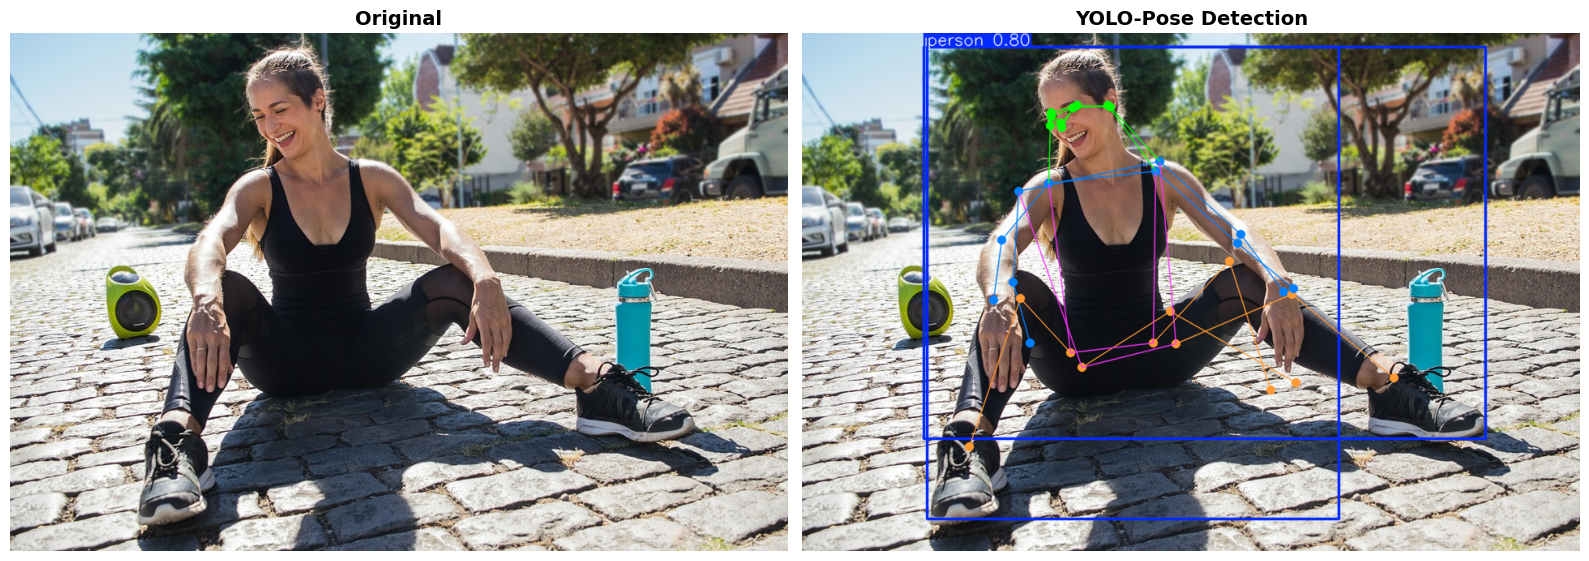


✓ Detected 2 person(s)

Keypoints for person 1:
ID          X        Y
------------------------
0       321.0    117.2
1       334.5     93.7
2       307.2    104.8
3       377.4     90.9
4       306.8    115.1
5       436.9    171.7
6       304.4    186.5
7       537.9    260.3
8       246.3    256.3
9       606.1    316.1
10      236.6    330.5
11      433.8    383.8
12      331.6    395.6
13      527.0    282.5
14      269.1    328.7
15      578.7    442.0
16      206.3    512.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Saved to: /content/yolo_pose_result.jpg


In [1]:
"""
YOLO-Pose - State-of-the-art pose estimation
Fastest and most accurate option
"""

!pip install -q ultralytics opencv-python matplotlib

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import os

# Load pre-trained YOLOv8 pose model
print("Loading YOLOv8-Pose model...")
model = YOLO('yolov8n-pose.pt')  # nano model (fast)
# model = YOLO('yolov8m-pose.pt')  # medium model (more accurate)

print("✓ Model loaded!")

# Process image
image_path = '/content/test_data/test.jpg'

if os.path.exists(image_path):
    print(f"\nProcessing: {image_path}")

    # Run inference
    results = model(image_path)

    # Get the result image with annotations
    annotated_image = results[0].plot()

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Original
    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    axes[0].imshow(original_rgb)
    axes[0].axis('off')
    axes[0].set_title('Original', fontsize=14, fontweight='bold')

    # Result
    result_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    axes[1].imshow(result_rgb)
    axes[1].axis('off')
    axes[1].set_title('YOLO-Pose Detection', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Save
    output_path = '/content/yolo_pose_result.jpg'
    cv2.imwrite(output_path, annotated_image)

    # Show keypoint data
    for r in results:
        if r.keypoints is not None:
            keypoints = r.keypoints.xy[0].cpu().numpy()  # Get first person
            print(f"\n✓ Detected {len(r.keypoints)} person(s)")
            print(f"\nKeypoints for person 1:")
            print(f"{'ID':<4} {'X':>8} {'Y':>8}")
            print("-" * 24)
            for i, kp in enumerate(keypoints):
                print(f"{i:<4} {kp[0]:>8.1f} {kp[1]:>8.1f}")

    # Download
    files.download(output_path)
    print(f"\n✓ Saved to: {output_path}")

else:
    print(f"✗ File not found: {image_path}")

## MoveNet

In [4]:
!pip install -q tensorflow tensorflow-hub opencv-python matplotlib

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load image
image = cv2.imread('/content/test_data/test.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load model
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

# CORRECT PREPROCESSING
image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.uint8)
image_tensor = tf.expand_dims(image_tensor, axis=0)
image_tensor = tf.image.resize_with_pad(image_tensor, 192, 192)
image_tensor = tf.cast(image_tensor, dtype=tf.int32)  # CRITICAL STEP

# Run inference
outputs = model.signatures['serving_default'](image_tensor)
keypoints = outputs['output_0'].numpy()

print(f"Success! Found {np.sum(keypoints[0, :, 2] > 0.3)} keypoints")

Success! Found 2 keypoints


TensorFlow version: 2.19.0
MOVENET SIMPLE WORKING VERSION

1️⃣ LOADING IMAGE
----------------------------------------
✅ Image loaded: 960x640 pixels

2️⃣ RUNNING INFERENCE
----------------------------------------
🔍 Keypoints shape: (1, 1, 17, 3)
🔍 Keypoints dtype: float32
🔍 Keypoints range: [0.065, 0.919]

3️⃣ VISUALIZING RESULTS
----------------------------------------
🔍 Raw keypoints shape: (1, 1, 17, 3)
🔍 Squeezed to shape: (1, 17, 3)
✅ Final keypoints shape: (1, 17, 3)
🔍 Visible keypoints at threshold 0.1: 16/17

KEYPOINT DETAILS
Body Part            X      Y Confidence   Status
-------------------------------------------------------
nose               320    189     0.516   ✅
left_eye           336    170     0.715   ✅
right_eye          306    174     0.679   ✅
left_ear           386    166     0.834   ✅
right_ear          316    175     0.736   ✅
left_shoulder      456    220     0.844   ✅
right_shoulder     291    230     0.919   ✅
left_elbow         553    292     0.508   ✅
ri

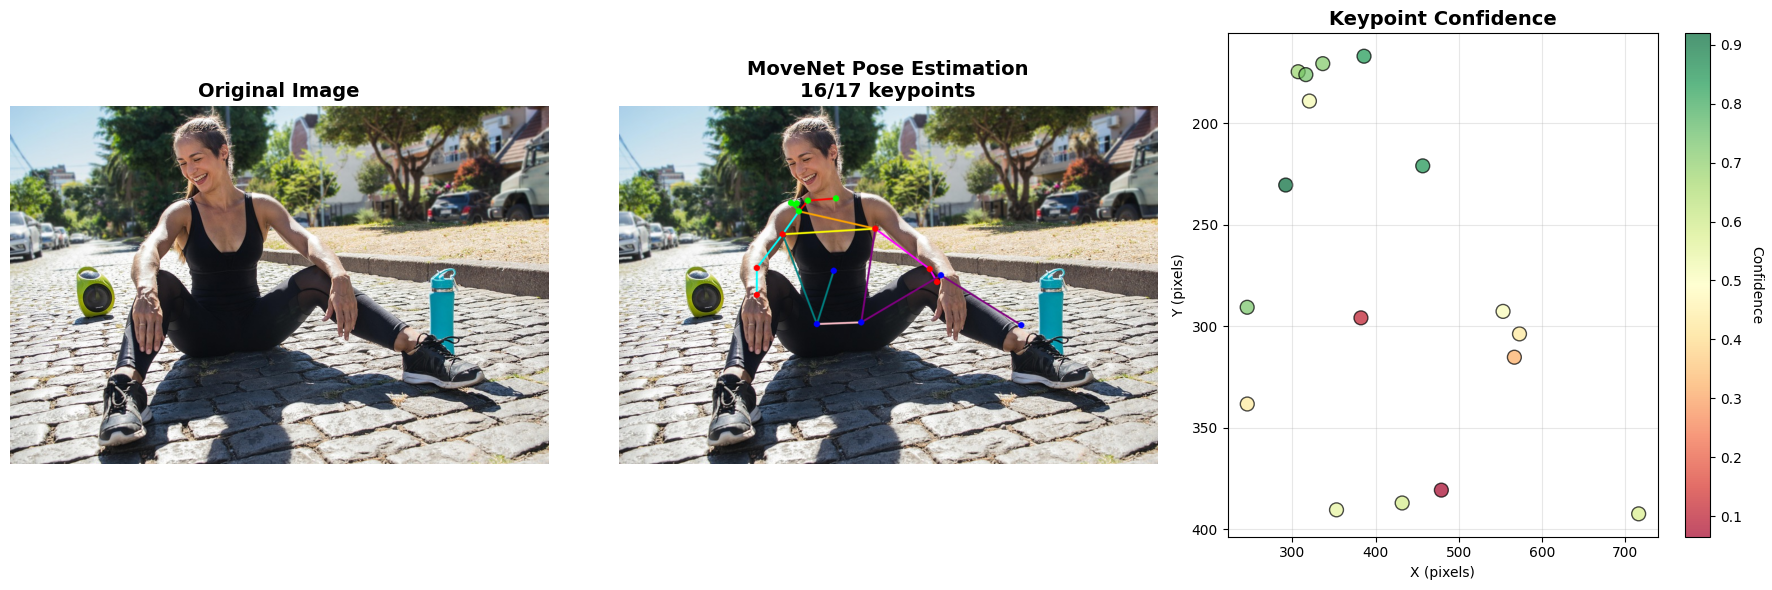


THRESHOLD TESTING
 Threshold    Visible   Percentage
-----------------------------------
      0.01          3        17.6%
      0.05          3        17.6%
      0.10          3        17.6%
      0.20          3        17.6%
      0.30          2        11.8%
      0.50          1         5.9%

💡 Recommended threshold: 0.1 (shows 3/17 keypoints)

5️⃣ SAVING RESULTS
----------------------------------------
✅ Saved: /content/movenet_result.jpg
✅ Saved: /content/keypoints_data.txt

🎉 PROCESSING COMPLETE!

📥 Download results:
  files.download('/content/movenet_result.jpg')
  files.download('/content/keypoints_data.txt')


In [7]:
"""
FIXED MoveNet Image Processor - Correct shape handling
"""

!pip install -q tensorflow tensorflow-hub opencv-python matplotlib

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os
import time

print(f"TensorFlow version: {tf.__version__}")

# Keypoint definitions for MoveNet (17 keypoints)
KEYPOINT_DICT = {
    'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
    'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
    'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
    'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
}

# Color-coded connections
KEYPOINT_EDGES = [
    (0, 1, (255, 0, 0)),    # Nose to Left Eye
    (0, 2, (0, 255, 0)),    # Nose to Right Eye
    (1, 3, (255, 0, 0)),    # Left Eye to Left Ear
    (2, 4, (0, 255, 0)),    # Right Eye to Right Ear
    (0, 5, (255, 165, 0)),  # Nose to Left Shoulder
    (0, 6, (0, 255, 255)),  # Nose to Right Shoulder
    (5, 6, (255, 255, 0)),  # Shoulders
    (5, 7, (255, 0, 255)),  # Left Shoulder to Left Elbow
    (7, 9, (255, 0, 255)),  # Left Elbow to Left Wrist
    (6, 8, (0, 255, 255)),  # Right Shoulder to Right Elbow
    (8, 10, (0, 255, 255)), # Right Elbow to Right Wrist
    (5, 11, (128, 0, 128)), # Left Shoulder to Left Hip
    (6, 12, (0, 128, 128)), # Right Shoulder to Right Hip
    (11, 12, (255, 192, 203)), # Hips
    (11, 13, (128, 0, 128)), # Left Hip to Left Knee
    (13, 15, (128, 0, 128)), # Left Knee to Left Ankle
    (12, 14, (0, 128, 128)), # Right Hip to Right Knee
    (14, 16, (0, 128, 128))  # Right Knee to Right Ankle
]

def load_and_prepare_image(image_path):
    """Load image and prepare for MoveNet"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Cannot load image from {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"✅ Image loaded: {image_rgb.shape[1]}x{image_rgb.shape[0]} pixels")
    return image_rgb

def run_movenet_simple(image_rgb, model_type="lightning"):
    """Simple MoveNet inference with correct shape handling"""
    # Load model
    if model_type == "lightning":
        model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    else:  # thunder
        model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256

    # Preprocess
    image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.uint8)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    image_tensor = tf.image.resize_with_pad(image_tensor, input_size, input_size)
    image_tensor = tf.cast(image_tensor, dtype=tf.int32)

    # Run inference
    outputs = model.signatures['serving_default'](image_tensor)
    keypoints = outputs['output_0'].numpy()

    # DEBUG: Print shape
    print(f"🔍 Keypoints shape: {keypoints.shape}")
    print(f"🔍 Keypoints dtype: {keypoints.dtype}")
    print(f"🔍 Keypoints range: [{keypoints.min():.3f}, {keypoints.max():.3f}]")

    return keypoints, input_size

def extract_keypoints_correctly(keypoints):
    """Extract keypoints with correct shape handling"""
    # MoveNet output shape is (1, 1, 17, 3) or (1, 17, 3)
    print(f"🔍 Raw keypoints shape: {keypoints.shape}")

    # Handle different possible shapes
    if len(keypoints.shape) == 4:
        # Shape is (1, 1, 17, 3) - squeeze the second dimension
        keypoints = keypoints.squeeze(1)  # Now (1, 17, 3)
        print(f"🔍 Squeezed to shape: {keypoints.shape}")

    # Ensure we have shape (1, 17, 3)
    if len(keypoints.shape) != 3 or keypoints.shape[1] != 17 or keypoints.shape[2] != 3:
        print(f"⚠ Unexpected shape: {keypoints.shape}, attempting to reshape")
        # Try to reshape to (1, 17, 3)
        keypoints = keypoints.reshape(1, 17, 3)

    print(f"✅ Final keypoints shape: {keypoints.shape}")
    return keypoints

def visualize_keypoints_simple(image_rgb, keypoints, confidence_threshold=0.1):
    """Simple visualization with correct shape handling"""
    height, width = image_rgb.shape[:2]
    annotated_image = image_rgb.copy()

    # Extract keypoints correctly
    keypoints = extract_keypoints_correctly(keypoints)

    # Scale keypoints from normalized [0,1] to image dimensions
    keypoints_scaled = keypoints.copy()
    keypoints_scaled[0, :, 0] *= height  # y coordinates
    keypoints_scaled[0, :, 1] *= width   # x coordinates

    # Count visible keypoints
    visible_mask = keypoints_scaled[0, :, 2] > confidence_threshold
    visible_count = np.sum(visible_mask)
    print(f"🔍 Visible keypoints at threshold {confidence_threshold}: {visible_count}/17")

    # Draw connections
    for start_idx, end_idx, color in KEYPOINT_EDGES:
        # Get keypoints
        y1, x1, conf1 = keypoints_scaled[0, start_idx]
        y2, x2, conf2 = keypoints_scaled[0, end_idx]

        # Check confidence
        if conf1 > confidence_threshold and conf2 > confidence_threshold:
            cv2.line(annotated_image,
                    (int(x1), int(y1)),
                    (int(x2), int(y2)),
                    color, 2, lineType=cv2.LINE_AA)

    # Draw keypoints
    for idx in range(17):
        y, x, conf = keypoints_scaled[0, idx]
        if conf > confidence_threshold:
            # Color by body part
            if idx in [0, 1, 2, 3, 4]:  # Face
                color = (0, 255, 0)  # Green
            elif idx in [5, 6, 7, 8, 9, 10]:  # Upper body
                color = (255, 0, 0)  # Blue
            else:  # Lower body
                color = (0, 0, 255)  # Red

            cv2.circle(annotated_image, (int(x), int(y)), 5, color, -1, lineType=cv2.LINE_AA)

    return annotated_image, keypoints_scaled

def display_keypoint_details(keypoints_scaled, confidence_threshold=0.1):
    """Display keypoint details"""
    print("\n" + "="*60)
    print("KEYPOINT DETAILS")
    print("="*60)
    print(f"{'Body Part':<15} {'X':>6} {'Y':>6} {'Confidence':>10} {'Status':>8}")
    print("-"*55)

    body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
                  'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
                  'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
                  'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

    for idx, name in enumerate(body_parts):
        y, x, conf = keypoints_scaled[0, idx]
        status = "✅" if conf > confidence_threshold else "❌"
        print(f"{name:<15} {int(x):>6} {int(y):>6} {conf:>9.3f}   {status}")

    visible_count = np.sum(keypoints_scaled[0, :, 2] > confidence_threshold)
    print(f"\n📊 Summary: {visible_count}/17 keypoints visible "
          f"({visible_count/17*100:.1f}%)")

def display_results_side_by_side(original_image, annotated_image, keypoints_scaled):
    """Display results"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')

    # Annotated
    visible_count = np.sum(keypoints_scaled[0, :, 2] > 0.1)
    axes[1].imshow(annotated_image)
    axes[1].axis('off')
    axes[1].set_title(f'MoveNet Pose Estimation\n{visible_count}/17 keypoints',
                     fontsize=14, fontweight='bold')

    # Confidence scatter plot
    keypoints = keypoints_scaled[0]
    scatter = axes[2].scatter(keypoints[:, 1], keypoints[:, 0],
                            c=keypoints[:, 2], cmap='RdYlGn',
                            s=100, alpha=0.7, edgecolors='black')
    axes[2].invert_yaxis()
    axes[2].set_title('Keypoint Confidence', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('X (pixels)')
    axes[2].set_ylabel('Y (pixels)')
    axes[2].grid(True, alpha=0.3)

    plt.colorbar(scatter, ax=axes[2]).set_label('Confidence', rotation=270, labelpad=15)
    plt.tight_layout()
    plt.show()

def test_different_thresholds(keypoints):
    """Test keypoint visibility at different thresholds"""
    print("\n" + "="*60)
    print("THRESHOLD TESTING")
    print("="*60)

    thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
    print(f"{'Threshold':>10} {'Visible':>10} {'Percentage':>12}")
    print("-"*35)

    for thresh in thresholds:
        visible = np.sum(keypoints[0, :, 2] > thresh)
        percentage = visible/17*100
        print(f"{thresh:>10.2f} {visible:>10} {percentage:>11.1f}%")

    # Recommend best threshold
    best_thresh = 0.1
    best_visible = np.sum(keypoints[0, :, 2] > best_thresh)
    print(f"\n💡 Recommended threshold: {best_thresh} (shows {best_visible}/17 keypoints)")

# MAIN FUNCTION - SIMPLE AND WORKING
def main():
    print("="*70)
    print("MOVENET SIMPLE WORKING VERSION")
    print("="*70)

    # Configuration
    IMAGE_PATH = '/content/test_data/test.jpg'
    CONFIDENCE_THRESHOLD = 0.1

    # Step 1: Load image
    print("\n1️⃣ LOADING IMAGE")
    print("-"*40)
    image_rgb = load_and_prepare_image(IMAGE_PATH)
    if image_rgb is None:
        # Download sample image
        os.makedirs('/content/test_data', exist_ok=True)
        print("📥 Downloading sample image...")
        !wget -q -O '/content/test_data/test.jpg' 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Two_dancers.jpg/640px-Two_dancers.jpg'
        image_rgb = load_and_prepare_image(IMAGE_PATH)
        if image_rgb is None:
            return

    # Step 2: Run inference
    print("\n2️⃣ RUNNING INFERENCE")
    print("-"*40)
    keypoints, input_size = run_movenet_simple(image_rgb, "lightning")

    # Step 3: Extract and visualize
    print("\n3️⃣ VISUALIZING RESULTS")
    print("-"*40)
    annotated_image, keypoints_scaled = visualize_keypoints_simple(
        image_rgb, keypoints, CONFIDENCE_THRESHOLD)

    # Step 4: Display details
    display_keypoint_details(keypoints_scaled, CONFIDENCE_THRESHOLD)

    # Step 5: Display results
    print("\n4️⃣ DISPLAYING IMAGES")
    print("-"*40)
    display_results_side_by_side(image_rgb, annotated_image, keypoints_scaled)

    # Step 6: Test thresholds
    test_different_thresholds(keypoints)

    # Step 7: Save results
    print("\n5️⃣ SAVING RESULTS")
    print("-"*40)
    output_path = '/content/movenet_result.jpg'
    annotated_bgr = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, annotated_bgr)
    print(f"✅ Saved: {output_path}")

    # Save keypoints
    data_path = '/content/keypoints_data.txt'
    with open(data_path, 'w') as f:
        f.write("MoveNet Keypoints\n")
        f.write("="*40 + "\n")
        for idx, name in KEYPOINT_DICT.items():
            y, x, conf = keypoints_scaled[0, name]
            f.write(f"{name:<15} {x:7.1f} {y:7.1f} {conf:.3f}\n")
    print(f"✅ Saved: {data_path}")

    print("\n" + "="*70)
    print("🎉 PROCESSING COMPLETE!")
    print("="*70)
    print(f"\n📥 Download results:")
    print(f"  files.download('{output_path}')")
    print(f"  files.download('{data_path}')")

    return annotated_image, keypoints_scaled

# MINIMAL WORKING VERSION
def minimal_working_version():
    """Minimal working version - use this if main() has issues"""
    print("🚀 MINIMAL WORKING VERSION")

    # Load image
    image = cv2.imread('/content/test_data/test.jpg')
    if image is None:
        !wget -q -O '/content/test_data/test.jpg' 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Two_dancers.jpg/640px-Two_dancers.jpg'
        image = cv2.imread('/content/test_data/test.jpg')

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load model
    model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

    # Preprocess
    image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.uint8)
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    image_tensor = tf.image.resize_with_pad(image_tensor, 192, 192)
    image_tensor = tf.cast(image_tensor, dtype=tf.int32)

    # Run inference
    outputs = model.signatures['serving_default'](image_tensor)
    keypoints = outputs['output_0'].numpy()

    # Debug shape
    print(f"Keypoints shape: {keypoints.shape}")

    # Reshape if needed
    if len(keypoints.shape) == 4:
        keypoints = keypoints.reshape(1, 17, 3)

    # Show results
    visible = np.sum(keypoints[0, :, 2] > 0.1)
    print(f"Found {visible}/17 keypoints with confidence > 0.1")

    # Show all confidences
    print("\nAll keypoint confidences:")
    for i in range(17):
        print(f"  Keypoint {i}: {keypoints[0, i, 2]:.3f}")

    return keypoints

# Run the script
if __name__ == "__main__":
    # Try the main function
    try:
        result_image, keypoints = main()
    except Exception as e:
        print(f"\n❌ Error in main: {e}")
        print("\nTrying minimal version...")
        keypoints = minimal_working_version()

        # Show what we got
        if keypoints is not None:
            print("\n✅ Minimal version succeeded!")
            print(f"Shape: {keypoints.shape}")
            print(f"Example keypoint [0]: {keypoints[0, 0]}")